In [2]:
# import libraries
import sys
import statsbombpy
from statsbombpy import sb
import pandas as pd
from pandas.io.json import json_normalize
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os, json
import numpy as np
from pitch_official import draw_pitch
import matplotsoccer
import scipy.ndimage
from matplotlib.patches import Arc

# Display options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 3000

# Display options for numpy
np.set_printoptions(linewidth=120, suppress=True)

# Display options for pyplot
%config InlineBackend.figure_format = 'retina'

## Cell computation timer
%load_ext autotime

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch, Pitch
from mplsoccer.cm import create_transparent_cmap
from matplotlib.patches import Arc
import glob
from mplsoccer.scatterutils import arrowhead_marker

from mplsoccer import VerticalPitch, add_image, FontManager
from mplsoccer.statsbomb import read_event, EVENT_SLUG


# Declaring credentials
credentials={'user':'vignesh.jayanth@staderennais.fr','passwd':'7XtHANc7'}

time: 216 ms (started: 2022-01-02 15:12:58 +01:00)


In [147]:
filename='/Users/vignesh.jayanth/Documents/Trial-Data Exports 2021/France_Ligue_1_2021_2022.ftr'


df = pd.read_feather(filename)

df2=df.copy()

df2=df2.sort_values(by=['match_id','index'], ascending=[True,True]).reset_index(drop=True)


time: 4.84 s (started: 2022-01-02 19:12:20 +01:00)


In [148]:

# subset data only for Ligue 1 and Rennes matches- Get corner Times #

df2['location'] = df2['location'].fillna({i: [] for i in df2.index})  # if the column is not strings
df2[['Start_x','Start_y','Start_z']] = pd.DataFrame(df2['location'].tolist(), index= df2.index).fillna(0)
df2['pass_end_location'] = df2['pass_end_location'].fillna({i: [] for i in df2.index})  # if the column is not strings
df2[['pass_end_x','pass_end_y']] = pd.DataFrame(df2['pass_end_location'].tolist(), index= df2.index).fillna('')

# Combine the necessary columns into one for uniformity #
df2['body_part_used'] = df2[['clearance_body_part', 'goalkeeper_body_part', 'pass_body_part','shot_body_part']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
df2['body_part_used']=df2['body_part_used'].str.replace('None','')
df2['technique'] = df2[['goalkeeper_technique', 'pass_technique', 'shot_technique']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
df2['technique']=df2['technique'].str.replace('None','')




time: 16.2 s (started: 2022-01-02 19:12:25 +01:00)


In [149]:
Corner=df2[(df2['play_pattern']=='From Corner')][['match_id','technique','team','minute','shot_statsbomb_xg',
                                                                        'second','body_part_used','player','id',
                                                                        'type','pass_type','pass_angle','Start_x',
                                                                        'Start_y','duration','pass_height','pass_end_x',
                                                                            'pass_end_y']]


Corner['play_flag'] = np.where(Corner['pass_type']=='Corner', 1, 0)
Corner['play_count'] = np.where(Corner['pass_type']=='Corner', Corner.groupby((Corner['play_flag'] != Corner['play_flag'].shift(1))).cumcount()+1, 0)
Corner['play_count'] = Corner.groupby((Corner['play_flag']!= Corner['play_flag'].shift(1)).cumsum()).cumcount()+1
Corner['play_count'] = np.where(Corner['play_flag']==1, 0, Corner['play_count'])

del Corner['play_flag']

# Set up a corner counter #

Corner_count=df2[(df2['pass_type']=='Corner')][['id']].reset_index(drop=True)
Corner_count['Corner_counter']=Corner_count.index

# Join the two data frames #

Corner=pd.merge(Corner,Corner_count,on='id',how='left')

Corner['Corner_counter']=Corner['Corner_counter'].fillna(method='ffill')
Corner['Corner_counter']=Corner['Corner_counter'].astype(int)

Corner['Corner_side']=np.where((Corner['pass_type']=='Corner')& (Corner['Start_y']<5),'Left','Right')

Corner['Corner_side']=Corner['Corner_side'].fillna(method='ffill')

# Subset the play count data upto 3 actions to see if there is a shot #

Corner=Corner[Corner['play_count']<=3].reset_index(drop=True)

# Bring all the players in the same scale - Defense is another scale #

Corner['Start_x']=np.where(Corner['Start_x']<60,120-Corner['Start_x'],Corner['Start_x'])

Corner[]



time: 1.34 s (started: 2022-01-02 19:12:41 +01:00)


In [152]:
corner_play=Corner[Corner['Corner_counter']==3].reset_index(drop=True)
id_list=list(corner_play.id.unique())
corner_play

match_id   technique    team  minute  shot_statsbomb_xg  second  \
0   3802624  Inswinging  Troyes      23                NaN      42   
1   3802624              Nantes      23                NaN      44   
2   3802624              Troyes      23                NaN      48   
3   3802624              Troyes      23                NaN      54   

  body_part_used                         player  \
0     Right Foot  Gerson Leal Rodrigues Gouveia   
1                                  Alban Lafont   
2                    Rominigue Kouamé N"Guessan   
3                    Rominigue Kouamé N"Guessan   

                                     id             type pass_type  \
0  98297646-7eae-4774-bfa7-9ce84448fa46             Pass    Corner   
1  f5c043f5-c7d2-4617-a561-11e307d96963      Goal Keeper      None   
2  1ab751cc-4b70-4335-b9b0-ee484e4f4ba9    Ball Recovery      None   
3  4445237c-a053-4567-80eb-0bdffc6d250a  Injury Stoppage      None   

   pass_angle  Start_x  Start_y  duration pass_height pass_end_x pass_end_y  \
0    1.692696    120.0      0.1  1.398129   High Pass      115.7       35.2   
1         NaN    115.6     44.9  0.000000        None                         
2         NaN     95.0     71.0  0.000000        None                         
3         NaN    120.0      0.0  0.000000        None                         

   play_count  Corner_counter Corner_side  
0           0               3        Left  
1           1               3       Right  
2           2               3       Right  
3           3               3       Right

time: 17.9 ms (started: 2022-01-02 19:39:11 +01:00)


In [123]:
# Read Frames data #

dfx=pd.read_feather('/Users/vignesh.jayanth/Documents/360 Data and event data/updated_comp_frames.ftr')

dfx=dfx.rename(columns={'event_uuid': 'id'})

time: 827 ms (started: 2022-01-02 18:14:50 +01:00)


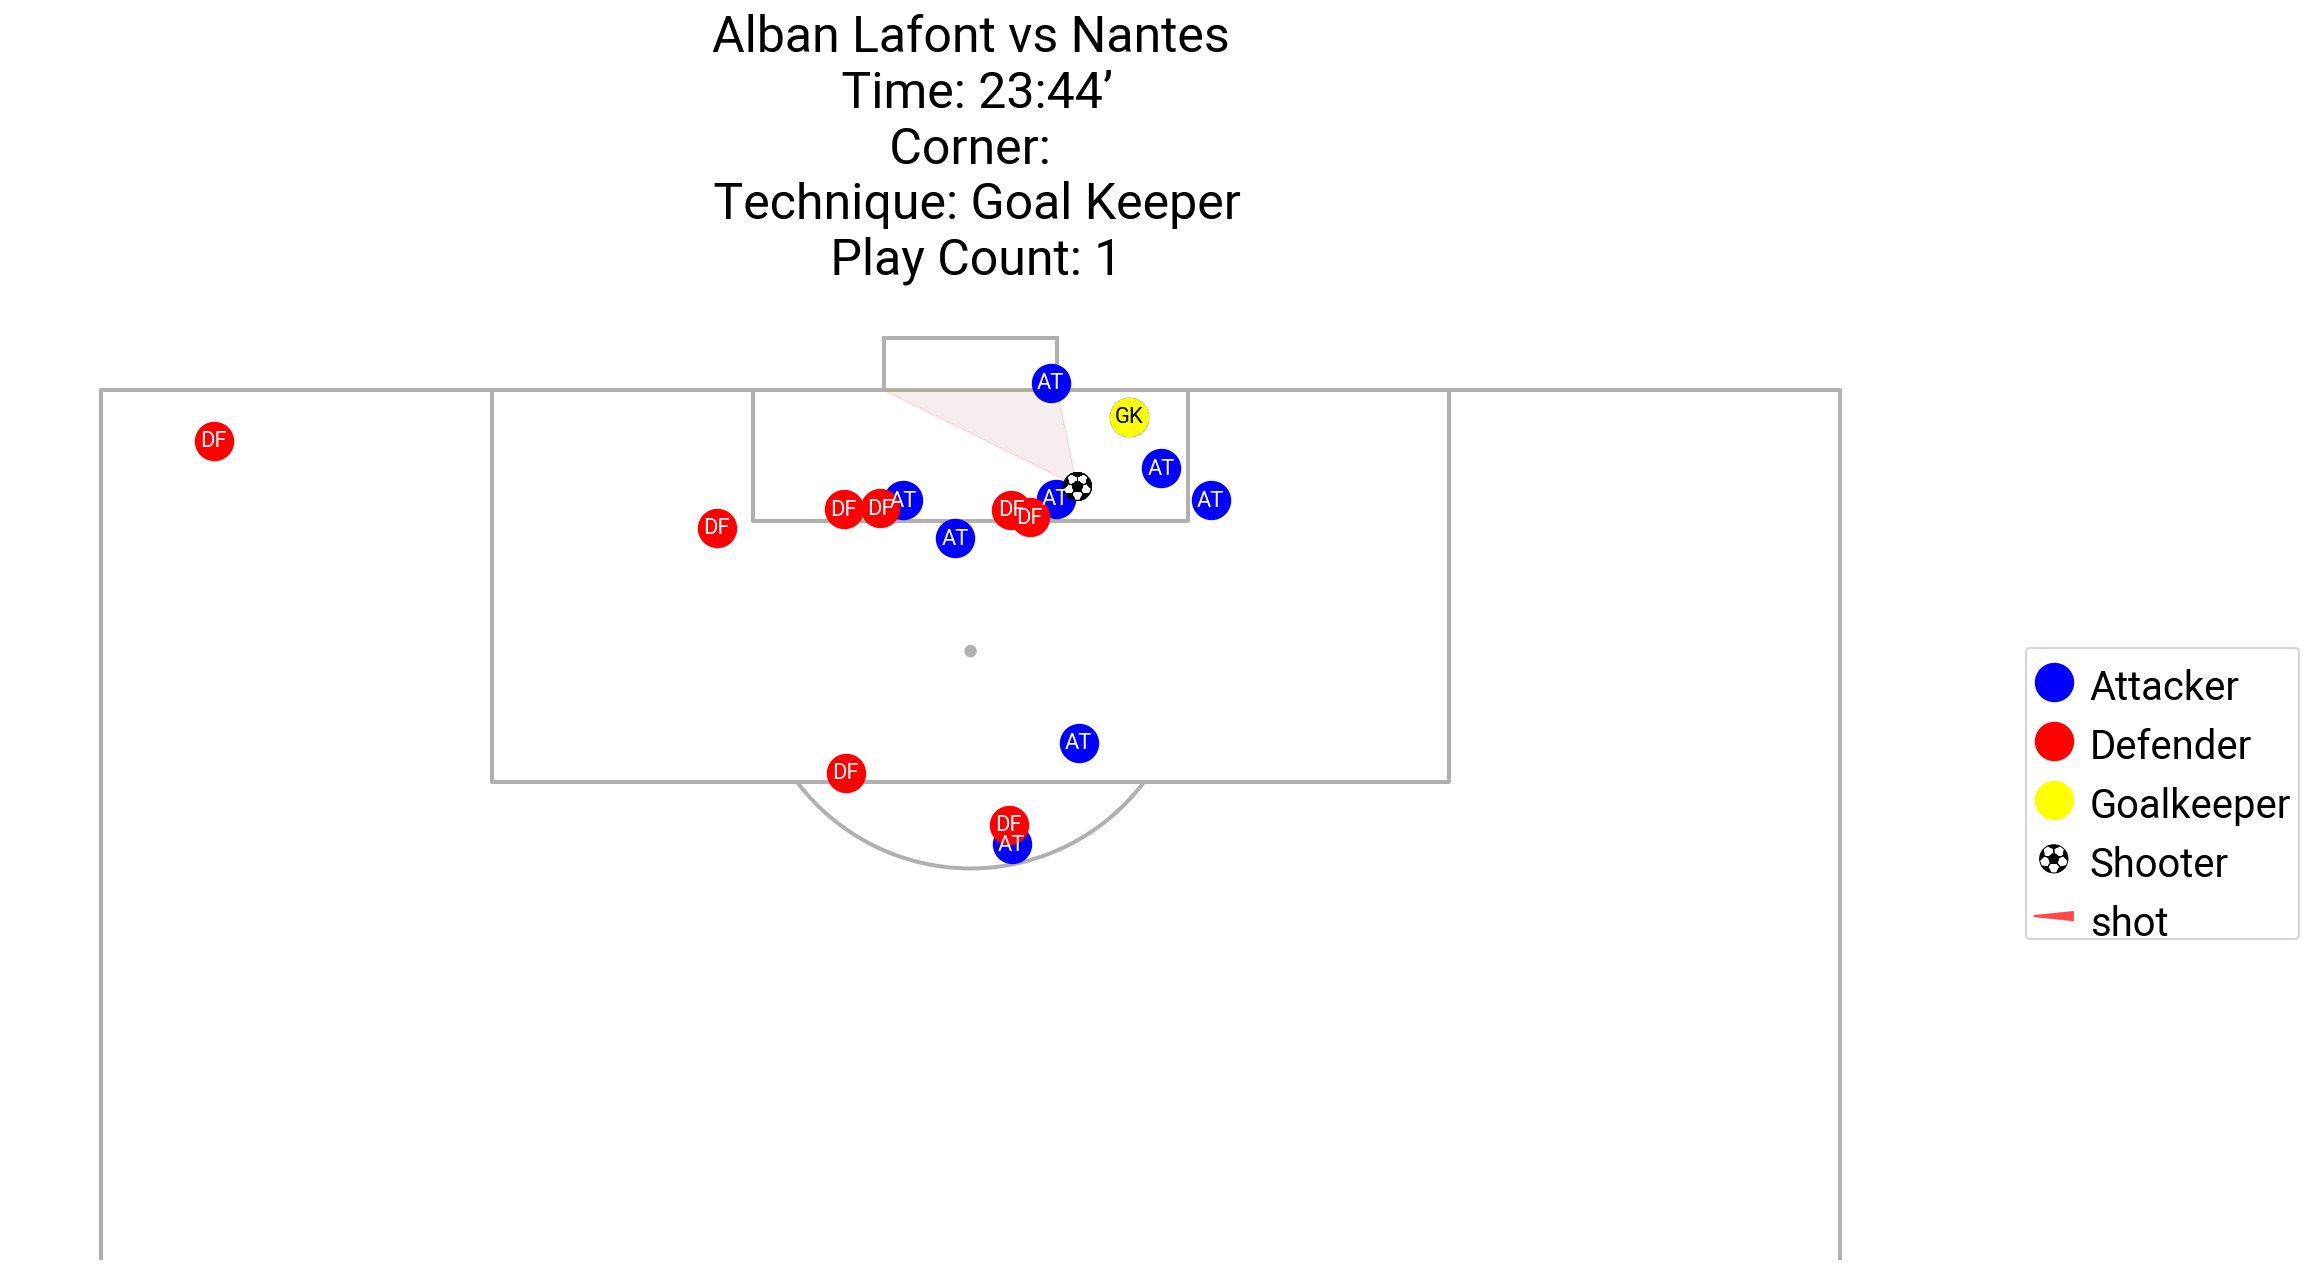

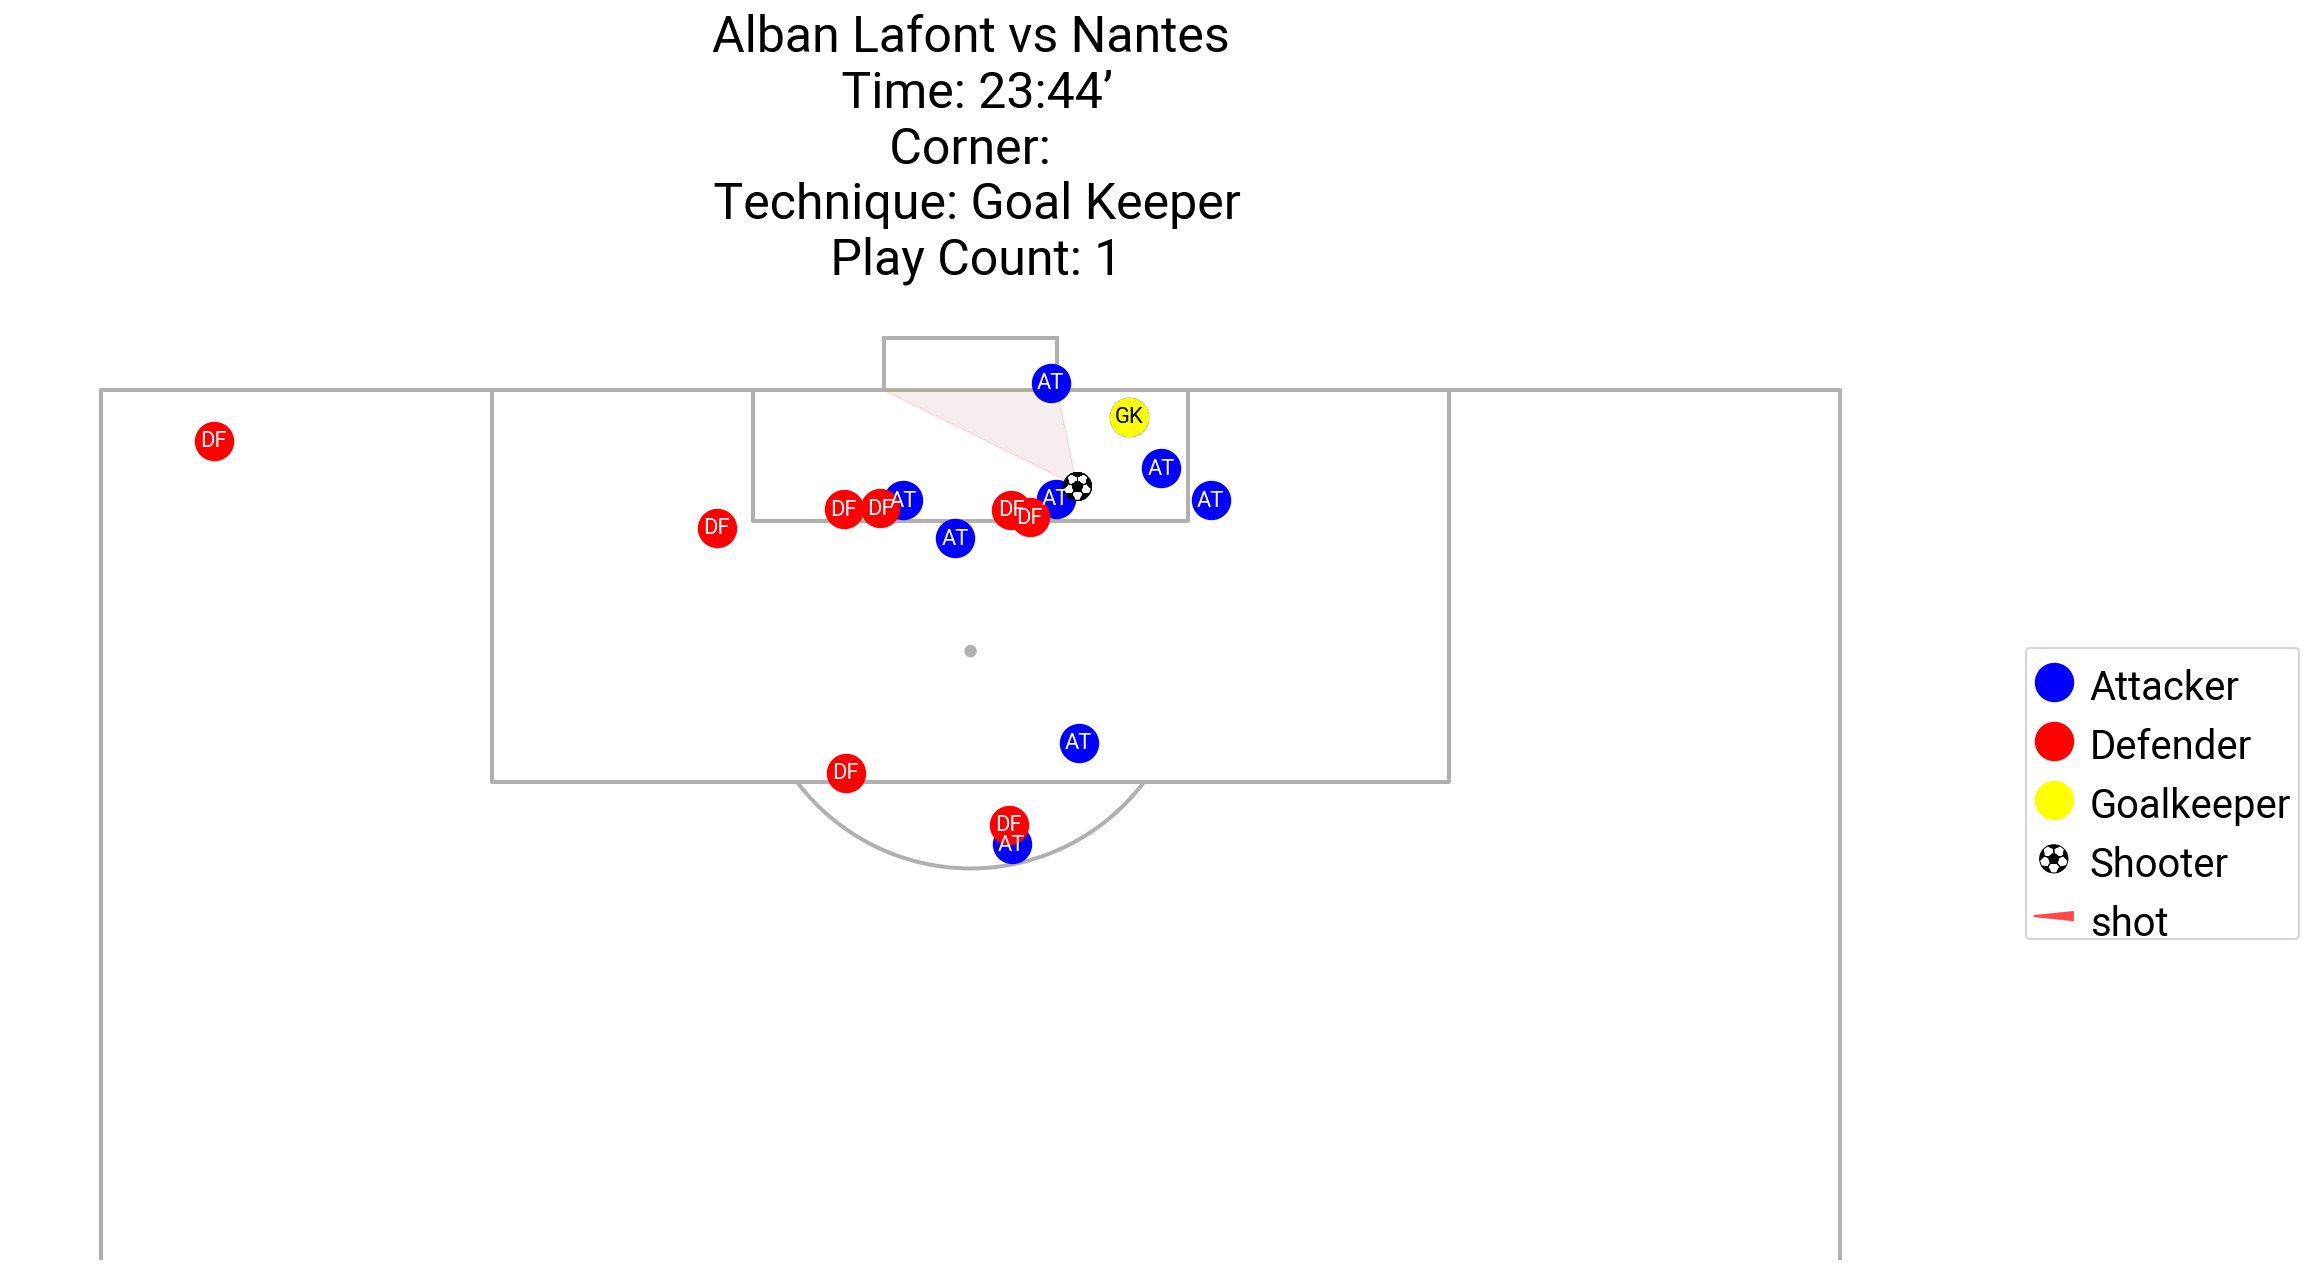

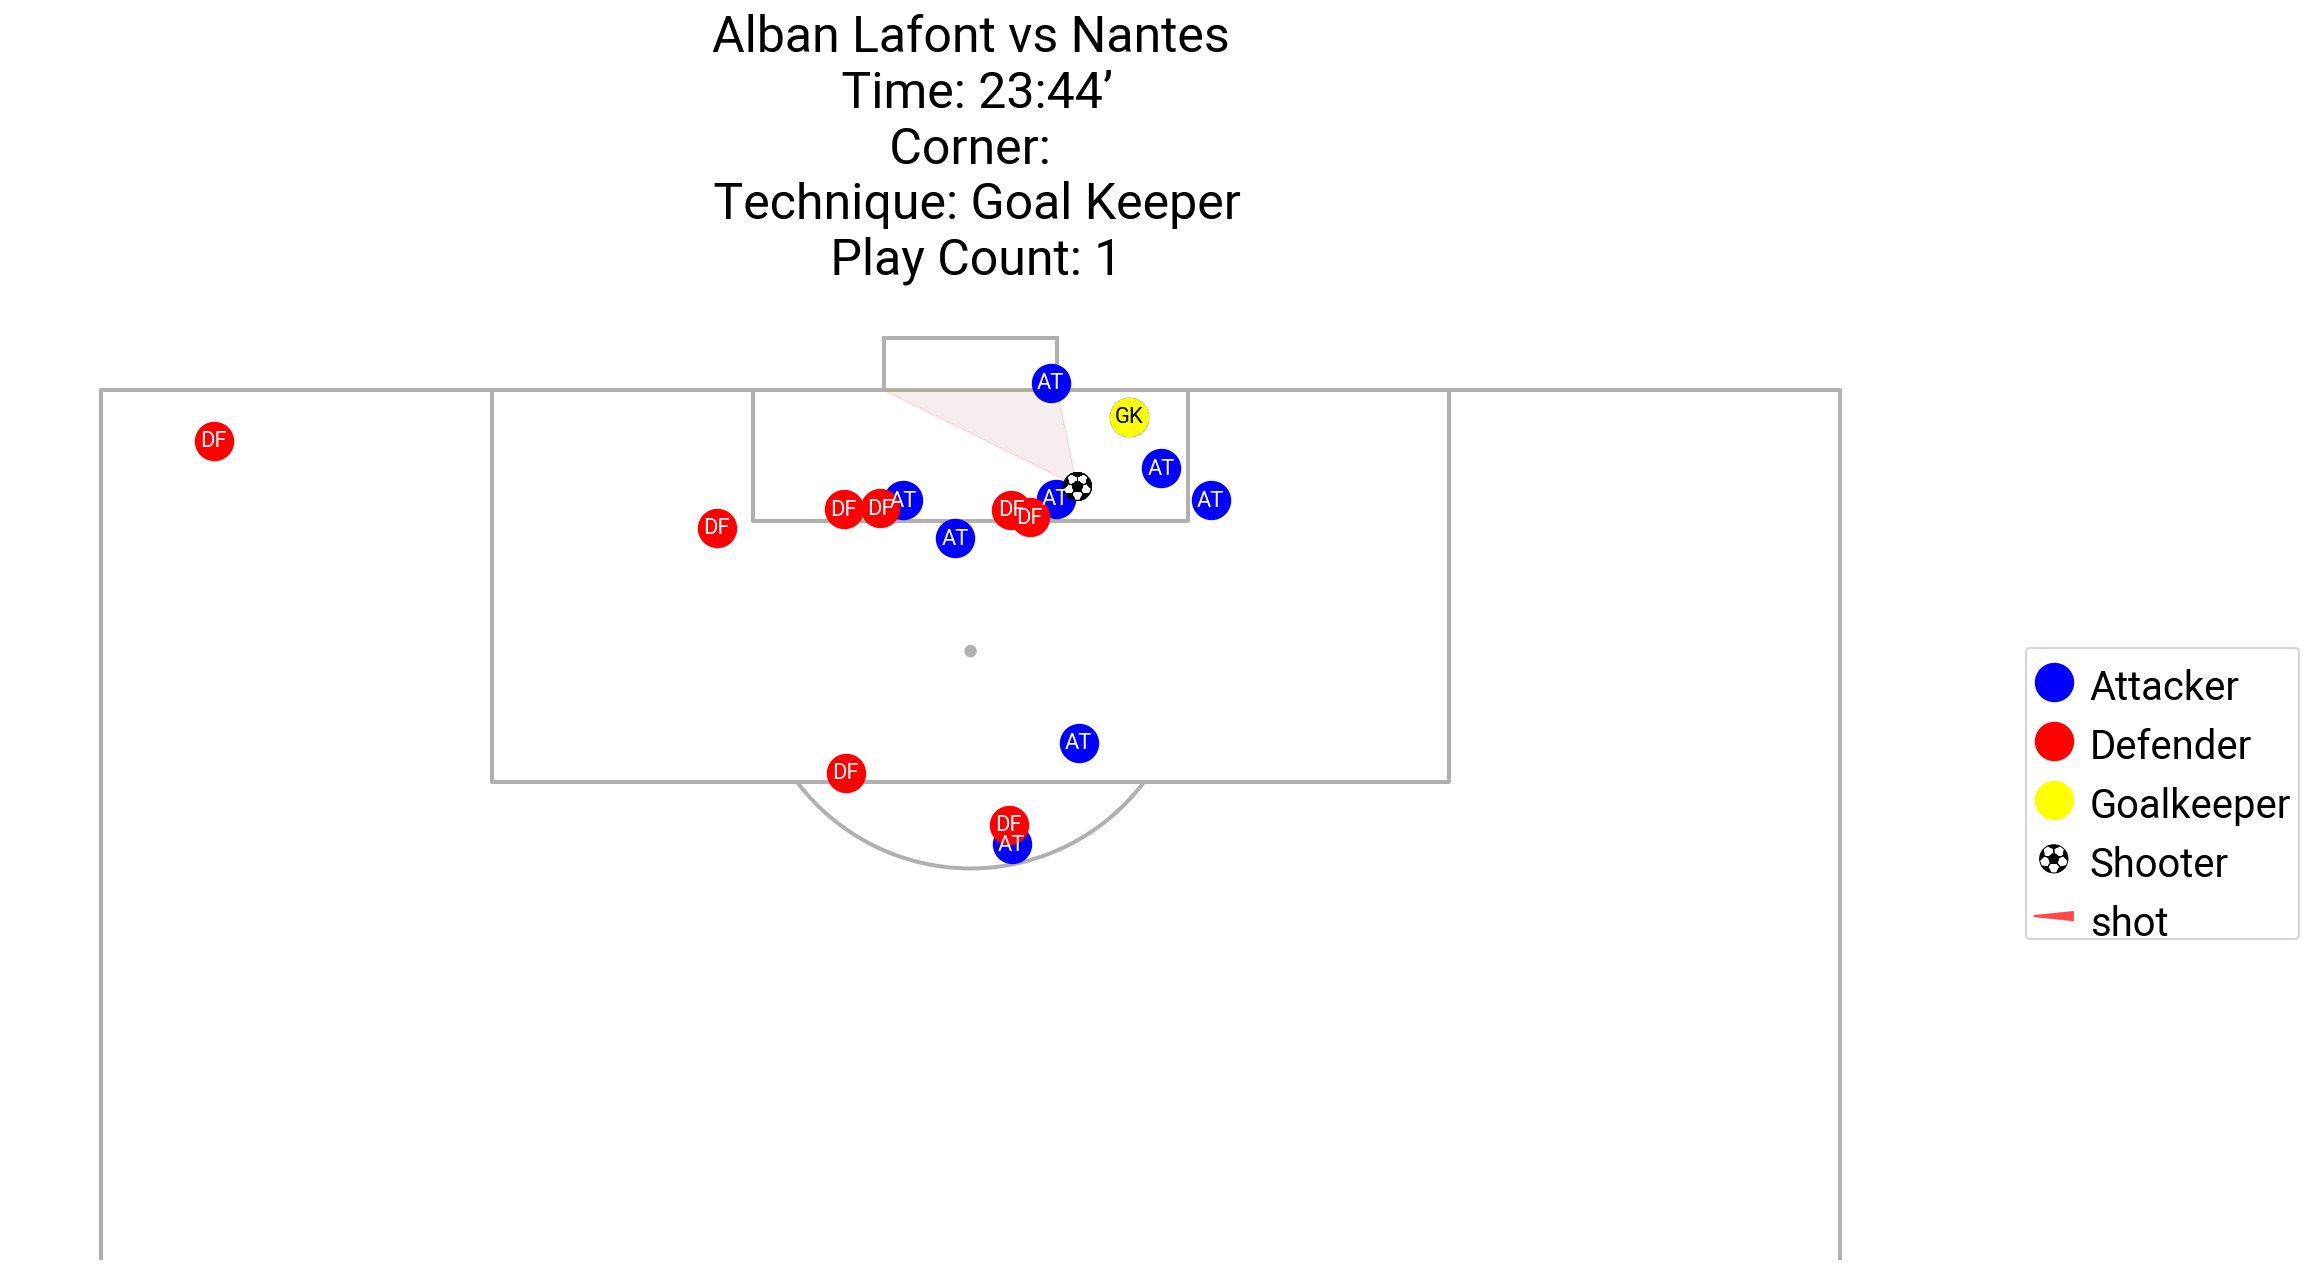

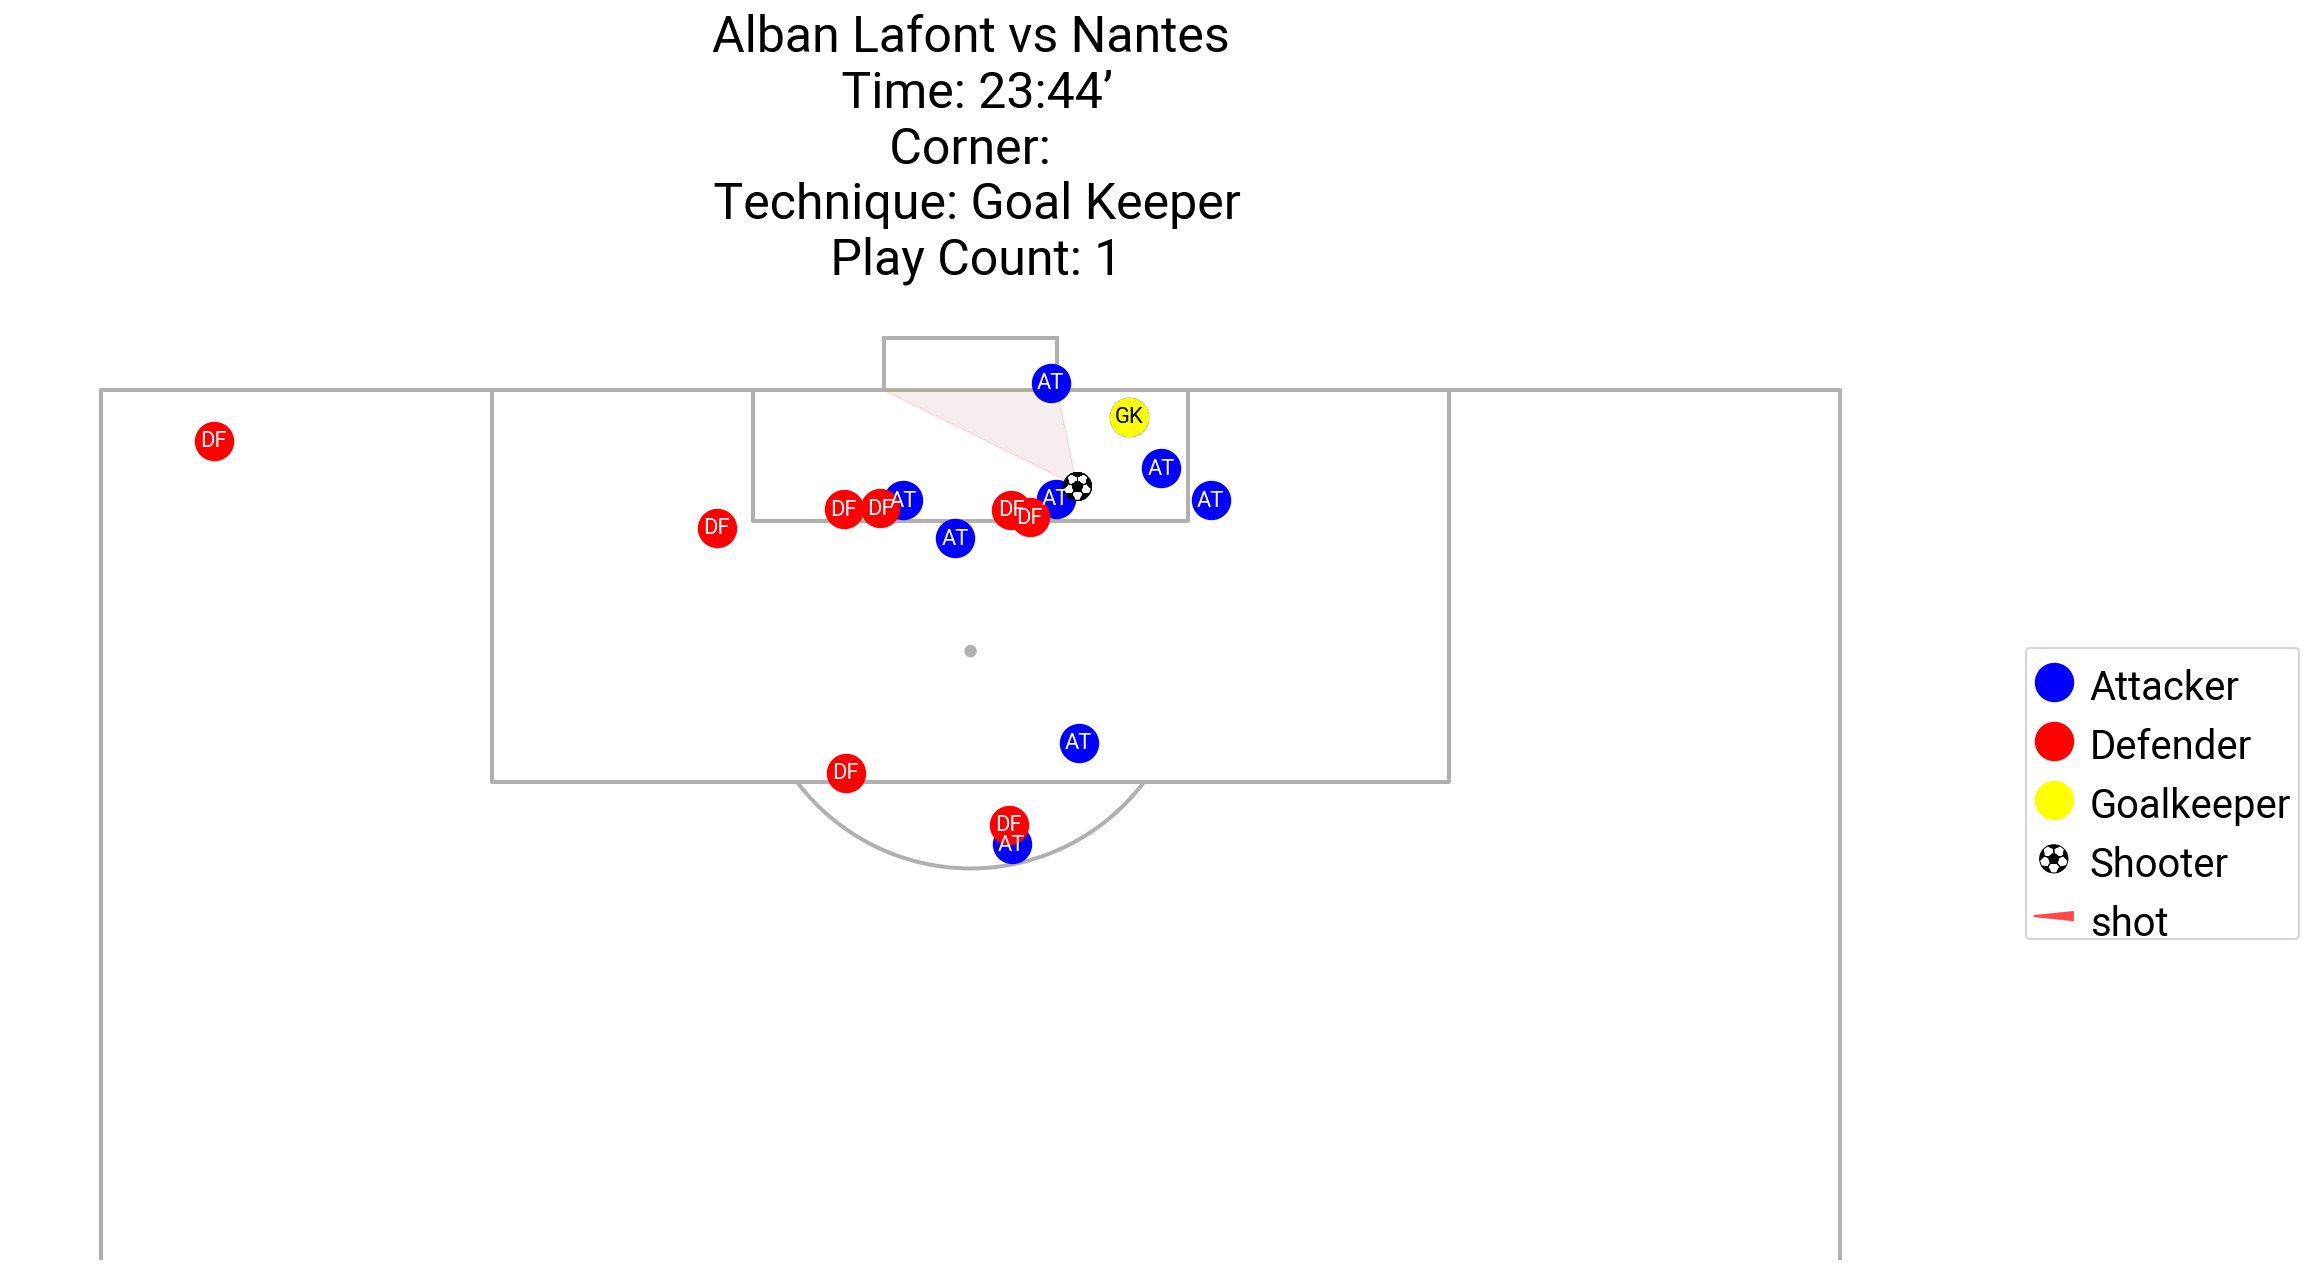

time: 4.98 s (started: 2022-01-02 19:52:31 +01:00)


In [158]:
for i in id_list:

    check=dfx[dfx['id']=='f5c043f5-c7d2-4617-a561-11e307d96963'].reset_index(drop=True)
    check=pd.merge(check,Corner,on='id',how='left')
    check['team']=np.where(check['teammate']==True,check['team'],'Opposition')
    check['team_type']=np.where(check['teammate']==True,'AT','DF')
    check['team_type']=np.where(check['keeper']==True,'GK',check['team_type'])
    check['x']=np.where(check['x']<60,120-check['x'],check['x'])
    check['y']=np.where(check['team']=='Opposition',80-check['y'],check['y'])
    check['pass_end_x']=np.where(check['pass_end_x']=='',check['Start_x'],check['pass_end_x'])
    check['pass_end_y']=np.where(check['pass_end_y']=='',check['Start_y'],check['pass_end_y'])

    # subset the team shooting, and the opposition (goalkeeper/ other)
    df_team1 = check[check.team != 'Opposition']
    df_team2_goal = check[check.keeper ==True]
    df_team2_other = check[(check.team == 'Opposition') & (check.keeper ==False)]


    team2=df_team1.team.unique()[0]

    Shooter=check.player[0]
    SO1=check.body_part_used[0]
    SO2=check.type[0]
    SO4=check.minute[0]
    SO5=check.second[0]
    SO6=check.play_count[0]

    # Setup the pitch
    pitch = VerticalPitch(pitch_type='statsbomb',half=True, goal_type='box', pad_bottom=-20)

    # We will use mplsoccer's grid function to plot a pitch with a title axis.
    fig, axs = pitch.grid(figheight=8, endnote_height=0,  # no endnote
                          title_height=0.1, title_space=0.02,
                          # Turn off the endnote/title axis. I usually do this after
                          # I am happy with the chart layout and text placement
                          axis=False,
                          grid_height=0.83)

    # Plot the players
    sc1 = pitch.scatter(df_team1.x, df_team1.y, s=350, c='blue', label='Attacker', ax=axs['pitch'])
    sc2 = pitch.scatter(df_team2_other.x, df_team2_other.y, s=350,
                        c='red', label='Defender', ax=axs['pitch'])
    sc4 = pitch.scatter(df_team2_goal.x, df_team2_goal.y, s=350,
                        ax=axs['pitch'], c='yellow', label='Goalkeeper')

    # plot the shot
    sc3 = pitch.scatter(check.Start_x, check.Start_y, marker='football',
                        s=200, ax=axs['pitch'], label='Shooter', zorder=1.2)
    line = pitch.lines(check.Start_x, check.Start_y,
                       check.pass_end_x, check.pass_end_y, comet=True,
                       label='shot', color='red', ax=axs['pitch'])

    # plot the angle to the goal
    pitch.goal_angle(check.Start_x, check.Start_y, ax=axs['pitch'], alpha=0.005, zorder=1.1,
                     color='#F6C244', goal='right')

    # fontmanager for google font (robotto)
    robotto_regular = FontManager()

    # plot the jersey numbers
    for i, label in enumerate(check.team_type):

        if label=='GK':

            pitch.annotate(label, (check.x[i], check.y[i]),
                       va='center', ha='center', color='black',weight='bold',
                       fontproperties=robotto_regular.prop, fontsize=11, ax=axs['pitch'])

        else:

            pitch.annotate(label, (check.x[i], check.y[i]),
               va='center', ha='center', color='white',weight='bold',
               fontproperties=robotto_regular.prop, fontsize=11, ax=axs['pitch'])



    # add a legend and title
    legend = axs['pitch'].legend(labelspacing=1,bbox_to_anchor=(1.2, 0.65))
    for text in legend.get_texts():
        text.set_fontproperties(robotto_regular.prop)
        text.set_fontsize(20)
        text.set_va('center')




    axs['title'].text(0.5, 0.9, f'{Shooter} vs {team2}\n Time: {SO4}:{SO5}’\n Corner: {SO1}\n Technique: {SO2}\n Play Count: {SO6}\n',
                      va='center', ha='center', color='black',
                      fontproperties=robotto_regular.prop, fontsize=25)


    # title
    plt.show()  # If you are using a Jupyter notebook you do not need this line

In [154]:
check

Empty DataFrame
Columns: [teammate, actor, keeper, index, x, y, match_id, technique, team, minute, shot_statsbomb_xg, second, body_part_used, player, id, type, pass_type, pass_angle, Start_x, Start_y, duration, pass_height, pass_end_x, pass_end_y, play_count, Corner_counter, Corner_side, team_type]
Index: []

time: 9.08 ms (started: 2022-01-02 19:49:00 +01:00)


In [ ]:
check=dfx[dfx['event_uuid']=='bb900e00-fc26-4fc1-a82d-c4874fab9aa7'].reset_index(drop=True)
check


In [142]:
check = df.filter(regex='technique')
print(check.columns)

Index(['goalkeeper_technique', 'pass_technique', 'shot_technique'], dtype='object')
time: 24 ms (started: 2022-01-02 19:09:49 +01:00)


In [ ]:
df2.pass_type.unique()

In [ ]:

path = '/Users/vignesh.jayanth/Documents/Trial-Data Exports 2021/' # use your path
all_files = glob.glob(path + "/*.ftr")

li = []

#all_files=['/Users/vignesh.jayanth/Documents/Trial-Data Exports 2021/All_combined.ftr']


for filename in all_files:
    df = pd.read_feather(filename)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

frame=frame[(frame['play_pattern']=='From Corner')].reset_index(drop=True)

frame.to_parquet('/Users/vignesh.jayanth/Documents/Trial-Data Exports 2021/All_combined.parquet.gzip',
              compression='gzip') 